In [11]:
import atlite
import matplotlib.pyplot as plt
from scipy.ndimage import label
import numpy as np
import json 
import pickle
import os  
import geopandas as gpd
from rasterio.plot import show  
from atlite.gis import shape_availability
import rasterio
import yaml
from utils.data_preprocessing import clean_region_name
from rasterstats import zonal_stats

dirname = os.getcwd() 
#main_dir = os.path.join(dirname, '..')
with open(os.path.join("configs/config.yaml"), "r", encoding="utf-8") as f:
    config = yaml.load(f, Loader=yaml.FullLoader) 

In [2]:
region_name = config['region_name'] #if country is studied, then use country name
region_name = clean_region_name(region_name)
print(region_name)

resampled = '' #'_resampled' 

# construct folder paths
dirname = os.getcwd() 
data_path = os.path.join(dirname, 'data', config['region_folder_name'])
data_from_DEM = os.path.join(data_path, 'derived_from_DEM')

# Load the CRS
# geo CRS
with open(os.path.join(data_path, region_name+'_global_CRS.pkl'), 'rb') as file:
        global_crs_obj = pickle.load(file)
# projected CRS
with open(os.path.join(data_path, region_name+'_local_CRS.pkl'), 'rb') as file:
        local_crs_obj = pickle.load(file)

print(f'geo CRS: {global_crs_obj}; projected CRS: {local_crs_obj}')

# Extract tag for filename, e.g., 'EPSG3035' or 'ESRI102003'
auth = global_crs_obj.to_authority()
global_crs_tag = ''.join(auth) if auth else global_crs_obj.to_string().replace(":", "_")
auth = local_crs_obj.to_authority()
local_crs_tag = ''.join(auth) if auth else local_crs_obj.to_string().replace(":", "_")

Elbe-Elster
geo CRS: EPSG:4326; projected CRS: EPSG:32633


In [3]:
# path to file and check if it exists and save 1 or 0 for later
landcoverPath=os.path.join(data_path, f'landcover_{config['landcover_source']}_{region_name}_{local_crs_tag}.tif')
landcover=0 if not os.path.isfile(landcoverPath) and print('no landcover file') is None else 1
demRasterPath = os.path.join(data_path, f'DEM_{region_name}_{global_crs_tag}{resampled}.tif')
dem=0 if not os.path.isfile(demRasterPath) and print('no DEM file') is None else 1
slopeRasterPath = os.path.join(data_from_DEM, f'slope_{region_name}_{global_crs_tag}{resampled}.tif')
slope=0 if not os.path.isfile(slopeRasterPath) and print('no slope file') is None else 1
windRasterPath = os.path.join(data_path, f'wind_{region_name}_{global_crs_tag}{resampled}.tif')
wind=0 if not os.path.isfile(windRasterPath) and print('no wind file') is None else 1
solarRasterPath = os.path.join(data_path, f'solar_{region_name}_{global_crs_tag}{resampled}.tif')
solar=0 if not os.path.isfile(solarRasterPath) and print('no solar file') is None else 1

regionPath =os.path.join(data_path, f'{region_name}_{local_crs_tag}.geojson')
region = gpd.read_file(regionPath)

northfacingRasterPath = os.path.join(data_from_DEM, f'north_facing_{region_name}_{global_crs_tag}{resampled}.tif')
nfacing=0 if not os.path.isfile(northfacingRasterPath) and print('no north facing pixels file') is None else 1
coastlinesPath = os.path.join(data_path, f'goas_{region_name}_{global_crs_tag}.gpkg')
coastlines=0 if not os.path.isfile(coastlinesPath) and print('no coastlines file') is None else 1
protectedAreasPath = os.path.join(data_path, f'protected_areas_{config['protected_areas_source']}_{region_name}_{global_crs_tag}.gpkg')
protectedAreas=0 if not os.path.isfile(protectedAreasPath) and print('no protected areas file') is None else 1
# OSM
roadsPath = os.path.join(data_path, f'OSM_roads_{region_name}_{global_crs_tag}.gpkg')
roads=0 if not os.path.isfile(roadsPath) and print('no roads file') is None else 1
railwaysPath = os.path.join(data_path, f'OSM_railways_{region_name}_{global_crs_tag}.gpkg')
railways=0 if not os.path.isfile(railwaysPath) and print('no railways file') is None else 1
airportsPath = os.path.join(data_path, f'OSM_airports_{region_name}_{global_crs_tag}.gpkg')
airports=0 if not os.path.isfile(airportsPath) and print('no airports file') is None else 1
waterbodiesPath = os.path.join(data_path, f'OSM_waterbodies_{region_name}_{global_crs_tag}.gpkg')
waterbodies=0 if not os.path.isfile(waterbodiesPath) and print('no waterbodies file') is None else 1
militaryPath = os.path.join(data_path, f'OSM_military_{region_name}_{global_crs_tag}.gpkg')
military=0 if not os.path.isfile(militaryPath) and print('no military file') is None else 1

# OSM overpass
substationsPath = os.path.join(data_path, f'OSM_substations_{region_name}_{global_crs_tag}.gpkg')
substations=0 if not os.path.isfile(substationsPath) and print('no substations file') is None else 1
transmissionPath = os.path.join(data_path, f'OSM_transmission_{region_name}_{global_crs_tag}.gpkg')
transmission=0 if not os.path.isfile(transmissionPath) and print('no transmission file') is None else 1




# additional exclusion polygons
additional_exclusion_polygons_Path = os.path.join(data_path, 'additional_exclusion_polygons')
additional_exclusion_polygons=0 if not os.path.exists(additional_exclusion_polygons_Path) and print('no additional exclusion polygon files') is None else 1

# load unique land use codes
with open(os.path.join(data_path, f'landuses_{region_name}.json'), 'r') as fp:
    landuses = json.load(fp)

# load pixel size
if config['resolution_manual'] is not None:
    res = config['resolution_manual']
else:
    with open(os.path.join(data_path, f'pixel_size_{region_name}_{local_crs_tag}.json'), 'r') as fp:
        res = json.load(fp)
    

print(landuses)
print(len(landuses))
print(res)

no wind file
no solar file
no north facing pixels file
no coastlines file
no protected areas file
no substations file
no transmission file
no additional exclusion polygon files
[0, 10, 30, 40, 50, 60, 80, 90]
8
6.915236813897402


In [4]:
info_list_exclusion = []

# initiate Exclusion container
excluder = atlite.ExclusionContainer(crs=local_crs_obj, res=res)

# add landcover exclusions
if config['landcover_without_buffer']:
    excluder.add_raster(landcoverPath, codes=config['landcover_without_buffer'],crs=local_crs_obj)
    info_list_exclusion.append(f'landcover codes without buffer which are excluded: {config['landcover_without_buffer']}')
else: print('landcover without buffer not selected in config.')
    
if config['landcover_with_buffer']:   
    for key, value in config['landcover_with_buffer'].items():
        excluder.add_raster(landcoverPath, codes=key, buffer=value ,crs=local_crs_obj)
    info_list_exclusion.append(f'landcover codes with buffer which are excluded: {config['landcover_with_buffer']}')
else: print('landcover with buffer not selected in config.')

# add elevation exclusions
if dem==1 and config['max_elevation'] is not None: 
    excluder.add_raster(demRasterPath, codes=range(config['max_elevation'],10000), crs=global_crs_obj)
    info_list_exclusion.append(f'max elevation: {config['max_elevation']}')
else: print('DEM file not found or not selected in config.')

# add slope exclusions
if slope==1 and config['max_slope'] is not None: 
    excluder.add_raster(slopeRasterPath, codes=range(config['max_slope'],90), crs=global_crs_obj)
    info_list_exclusion.append(f'max slope: {config['max_slope']}')
else: print('Slope file not found or not selected in config.')

# add north facing exclusion
if nfacing==1  and config['north_facing_pixels'] is not None: 
    excluder.add_raster(northfacingRasterPath, codes=1, crs=global_crs_obj)
    info_list_exclusion.append(f'north facing pixels')
else: print('North-facing file not found or not selected in config.')

# add wind exclusions
def wind_filter(mask):
    if config['min_wind_speed'] is not None and config['max_wind_speed'] is not None:
        return (mask < config['min_wind_speed']) | (mask > config['max_wind_speed'])
    elif config['min_wind_speed'] is not None:
        return mask < config['min_wind_speed']
    elif config['max_wind_speed'] is not None:
        return mask > config['max_wind_speed']
    
if wind==1 and (config['min_wind_speed'] is not None or config['max_wind_speed'] is not None): 
    excluder.add_raster(windRasterPath, codes=wind_filter, crs=global_crs_obj)
    if config['min_wind_speed'] is not None and config['max_wind_speed'] is not None: info=f'min wind speed: {config['min_wind_speed']}, max wind speed: {config['max_wind_speed']}'
    elif config['min_wind_speed'] is not None: info=f'min wind speed: {config['min_wind_speed']}'
    elif config['max_wind_speed'] is not None: info=f'max wind speed: {config['max_wind_speed']}'
    info_list_exclusion.append(f'{info}')
else: print('Wind file not found or not selected in config.')

# add solar exclusions
def solar_filter(mask): #desired yearly, specific solar production (kWh/kW) 
    if config['min_solar_production'] is not None and config['max_solar_production'] is not None:
        return (mask < config['min_solar_production']) | (mask > config['max_solar_production'])
    elif config['min_solar_production'] is not None:
        return mask < config['min_solar_production']
    elif config['max_solar_production'] is not None:
        return mask > config['max_solar_production']
    
if solar==1 and (config['min_solar_production'] is not None or config['max_solar_production'] is not None): 
    excluder.add_raster(solarRasterPath, codes=solar_filter, crs=global_crs_obj)
    if config['min_solar_production'] is not None and config['max_solar_production'] is not None: info=f'min_solar_production: {config['min_solar_production']}, max_solar_production: {config['max_solar_production']}'
    elif config['min_solar_production'] is not None: info=f'min_solar_production: {config['min_solar_production']}'
    elif config['max_solar_production'] is not None: info=f'max_solar_production: {config['max_solar_production']}'
    info_list_exclusion.append(f'{info}')
else: print('Solar file not found or not selected in config.')


# add exclusions from vector data
if railways==1 and config['railways_buffer'] is not None: 
    excluder.add_geometry(railwaysPath, buffer=config['railways_buffer'])
    info_list_exclusion.append(f'railways buffer: {config['railways_buffer']}')
else: print('Railways file not found or not selected in config.')

if roads==1 and config['roads_buffer'] is not None: 
    excluder.add_geometry(roadsPath, buffer=config['roads_buffer'])
    info_list_exclusion.append(f'roads buffer: {config['roads_buffer']}')
else: print('Roads file not found or not selected in config.')

if airports==1 and config['airports_buffer'] is not None: 
    excluder.add_geometry(airportsPath, buffer=config['airports_buffer'])
    info_list_exclusion.append(f'airports buffer: {config['airports_buffer']}')
else: print('Airports file not found or not selected in config.')

if waterbodies==1 and config['waterbodies_buffer'] is not None: 
    excluder.add_geometry(waterbodiesPath, buffer=config['waterbodies_buffer'])
    info_list_exclusion.append(f'waterbodies buffer: {config['waterbodies_buffer']}')
else: print('Waterbodies file not found or not selected in config.')

if military==1 and config['military_buffer'] is not None: 
    excluder.add_geometry(militaryPath, buffer=config['military_buffer'])
    info_list_exclusion.append(f'military buffer: {config['military_buffer']}')
else: print('Military file not found or not selected in config.')

if coastlines==1 and config['coastlines_buffer'] is not None: 
    excluder.add_geometry(coastlinesPath, buffer=config['coastlines_buffer'])
    info_list_exclusion.append(f'coastlines buffer: {config['coastlines_buffer']}')
else: print('Coastlines file not found or not selected in config.')

if protectedAreas==1 and config['protectedAreas_buffer'] is not None: 
    excluder.add_geometry(protectedAreasPath, buffer=config['protectedAreas_buffer'])
    info_list_exclusion.append(f'protected areas buffer: {config['railways_buffer']}')
else: print('Protected Areas file not found or not selected in config.')

# OSM overpass
if substations==1 and config['substations_inclusion_buffer'] is not None: 
    excluder.add_geometry(substationsPath, buffer=config['substations_inclusion_buffer'], invert=True)
    info_list_exclusion.append(f'substations inclusion buffer: {config['substations_inclusion_buffer']}')
else: print('Substations file not found or not selected in config.')

if transmission==1 and config['transmission_inclusion_buffer'] is not None: 
    excluder.add_geometry(transmissionPath, buffer=config['transmission_inclusion_buffer'], invert=True)
    info_list_exclusion.append(f'transmission inclusion buffer: {config['transmission_inclusion_buffer']}')
else: print('Transmission file not found or not selected in config.')



# add additional exclusion polygons
if additional_exclusion_polygons==1 and config['additional_exclusion_polygons_buffer']:   
    for i, (buffer_value, filename) in enumerate(zip(config['additional_exclusion_polygons_buffer'], os.listdir(additional_exclusion_polygons_Path))):
        filepath = os.path.join(additional_exclusion_polygons_Path, filename)    # Construct the full file path
        excluder.add_geometry(filepath, buffer=buffer_value)
        info_list_exclusion.append(f'additional exclusion polygon file {i+1}: {buffer_value}')
else: print('additional exclusion polygon files not found or not selected in config.')




# calculate available areas
masked, transform = shape_availability(region.geometry, excluder)

available_area = masked.sum() * excluder.res**2
eligible_share = available_area / region.geometry.item().area
power_potential = available_area*1e-6 * config['deployment_density']
print()
print(f"The eligibility share is: {eligible_share:.2%}")
print()
print(f'The available area is: {available_area:.2}')
print()
print(f'Power potential: {power_potential:.2} MW')

print()
print('following data was considered during exclusion:')
for item in info_list_exclusion:
    print('- ', item)

landcover without buffer not selected in config.
DEM file not found or not selected in config.
Slope file not found or not selected in config.
North-facing file not found or not selected in config.
Wind file not found or not selected in config.
Solar file not found or not selected in config.
Railways file not found or not selected in config.
Roads file not found or not selected in config.
Airports file not found or not selected in config.
Waterbodies file not found or not selected in config.
Military file not found or not selected in config.
Coastlines file not found or not selected in config.
Protected Areas file not found or not selected in config.
Substations file not found or not selected in config.
Transmission file not found or not selected in config.
additional exclusion polygon files not found or not selected in config.


c:\Users\b396636\AppData\Local\anaconda3\envs\lava\Lib\site-packages\atlite\gis.py:480: RasterioDeprecationWarning: is_valid is not useful and will be removed in 2.0.0.
  if not raster.crs.is_valid if raster.crs is not None else True:



The eligibility share is: 90.45%

The available area is: 1.7e+09

Power potential: 8.6e+04 MW

following data was considered during exclusion:
-  landcover codes with buffer which are excluded: {50: 50}


In [31]:
modelAreasPath =os.path.join(data_path, f'EE_split.geojson')
model_areas = gpd.read_file(modelAreasPath)
model_areas.to_crs(local_crs_obj, inplace=True)
model_areas

,GID_2,GID_0,NAME_0,GID_1,NAME_1,NL_NAME_1,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
0,DEU.4.5_1,DEU,Germany,DEU.4_1,Brandenburg,NA,Elbe-Elster,NA,NA,Landkreis,District,12062,DE.BB.EE,"MULTIPOLYGON (((394301.214 5720795.418, 417400..."
1,DEU.4.5_1,DEU,Germany,DEU.4_1,Brandenburg,NA,Elbe-Elster,NA,NA,Landkreis,District,12062,DE.BB.EE,"MULTIPOLYGON (((394301.214 5720795.418, 374379..."
2,DEU.4.5_1,DEU,Germany,DEU.4_1,Brandenburg,NA,Elbe-Elster,NA,NA,Landkreis,District,12062,DE.BB.EE,"MULTIPOLYGON (((417400.682 5730888.301, 394301..."
3,DEU.4.5_1,DEU,Germany,DEU.4_1,Brandenburg,NA,Elbe-Elster,NA,NA,Landkreis,District,12062,DE.BB.EE,"MULTIPOLYGON (((374379.57 5712207.698, 394301...."


<Axes: >

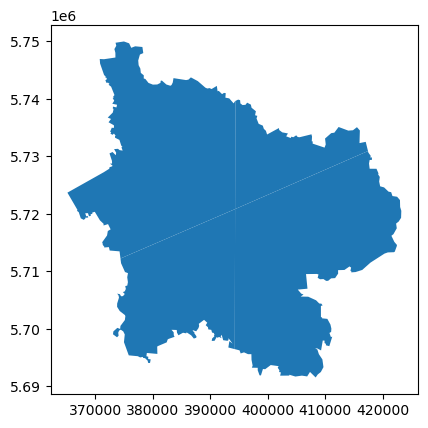

In [32]:
model_areas.plot()

In [33]:
# Define output directory
output_dir = os.path.join(data_path, 'available_land')
os.makedirs(output_dir, exist_ok=True)

raster_filePath = os.path.join(output_dir, f'{config['scenario']}_available_land_filtered-min0_{region_name}_{local_crs_tag}.tif')

In [34]:
stats = zonal_stats(model_areas,
                    raster_filePath,
                    stats=['sum'])

In [35]:
stats

[{'sum': 12669959.0},
 {'sum': 12396510.0},
 {'sum': 3969964.0},
 {'sum': 6874216.0}]

In [38]:
model_areas['pixel_count'] = [list(d.values())[0] for d in stats]
model_areas['available_area_m2'] = model_areas['pixel_count'] * excluder.res**2
model_areas['available_area_km2'] = model_areas['pixel_count'] *1e-6
model_areas['power_potential_MW'] = (model_areas['available_area_m2']*1e-6) * config['deployment_density']
model_areas

,GID_2,GID_0,NAME_0,GID_1,NAME_1,NL_NAME_1,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry,pixel_count,available_area_m2,power_potential_MW,available_area_km2
0,DEU.4.5_1,DEU,Germany,DEU.4_1,Brandenburg,NA,Elbe-Elster,NA,NA,Landkreis,District,12062,DE.BB.EE,"MULTIPOLYGON (((394301.214 5720795.418, 417400...",12669959.0,6.058838e+08,30294.188840,12.669959
1,DEU.4.5_1,DEU,Germany,DEU.4_1,Brandenburg,NA,Elbe-Elster,NA,NA,Landkreis,District,12062,DE.BB.EE,"MULTIPOLYGON (((394301.214 5720795.418, 374379...",12396510.0,5.928073e+08,29640.365442,12.396510
2,DEU.4.5_1,DEU,Germany,DEU.4_1,Brandenburg,NA,Elbe-Elster,NA,NA,Landkreis,District,12062,DE.BB.EE,"MULTIPOLYGON (((417400.682 5730888.301, 394301...",3969964.0,1.898457e+08,9492.283211,3.969964
3,DEU.4.5_1,DEU,Germany,DEU.4_1,Brandenburg,NA,Elbe-Elster,NA,NA,Landkreis,District,12062,DE.BB.EE,"MULTIPOLYGON (((374379.57 5712207.698, 394301....",6874216.0,3.287284e+08,16436.422377,6.874216


In [40]:
# Get the name of the first column (usually an ID or name)
first_column = model_areas.columns[0]

columns = [first_column, "pixel_count", "available_area_m2", "available_area_km2", "power_potential_MW"]
subset = model_areas[columns]

subset

,GID_2,pixel_count,available_area_m2,available_area_km2,power_potential_MW
0,DEU.4.5_1,12669959.0,6.058838e+08,12.669959,30294.188840
1,DEU.4.5_1,12396510.0,5.928073e+08,12.396510,29640.365442
2,DEU.4.5_1,3969964.0,1.898457e+08,3.969964,9492.283211
3,DEU.4.5_1,6874216.0,3.287284e+08,6.874216,16436.422377
